In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
from varname import nameof

import requests
from bs4 import BeautifulSoup
import html
import lxml

In [2]:
def num_cleaning(x):
    try:
        return re.match(r'[\d]*[\.\d]*', x)[0]
    except:
        return x

def to_float(x):
    try:
        return float(x)
    except:
        return x

def mapper(data):
    try:
        data.shape[1]       # This is actually to check whether it is a DataFrame or not
        return data.applymap(num_cleaning).applymap(to_float)
    except:
        return data.map(num_cleaning).map(to_float)

def gram_to_liter(x):
    return x * 0.001

def iu_to_mcg(x):
    # This is from international units to mcg retinol
    # I'll use this function to convert vimain a units to something that I can compare with the australian recommendation for daily intake
    return x * 0.3

def key_nutrients():
    return ["protein", "water", "fiber", "vitamin_a", "thiamin", "riboflavin", "niacin", "vitamin_b6", "vitamin_b12", "folate", "vitamin_c", "calcium", "irom", "magnesium", "potassium", "sodium", "zink"]



In [3]:
def nutrition_prep(filename):
    nutrition = pd.read_csv(filename)
    nutrition.set_index("name", inplace = True)

    filter_ = key_nutrients()

    nutrition = nutrition[filter_]

    nutrition = mapper(nutrition)

    nutrition["water"] = nutrition["water"].map(gram_to_liter)
    nutrition["vitamin_a"] = nutrition["vitamin_a"].map(iu_to_mcg)

    return nutrition

In [4]:
def food_selector(foodname, df):
    return df.loc[foodname]

In [5]:
def dailyintake_info(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, "lxml")

    di_table = soup.find(id = "tbl-calc")
    di_rows = di_table.find_all("tr")

    di_dict = {}

    for row in di_rows:
        items = row.find_all("td")
        if len(items) > 1:
            di_dict[items[0].text] = items[1].text

    s = pd.Series(di_dict)

    return s

In [6]:
def dailyintake_prep(serie):
    serie = mapper(serie)
    serie.drop("Iodine", inplace = True)
    serie.name = nameof(serie)
    serie.index = key_nutrients()
    return serie

In [7]:
def foodquality(food, dailyintake):
    if len(food) == len(dailyintake):
        s = (food / dailyintake) * 100
        s = s.sort_values(ascending = False)
        s = s.reset_index()
        s.columns = ["nutrient", "%OfDailyIntake"]
        return s

In [8]:
foodname = "Cauliflower, raw"
filename = "../data/Nutritional_values.csv"
url_w_30 = "https://www.eatforhealth.gov.au/node/1813927/done?sid=806757&token=05ce5572f5618ac641c9f2395b28c59f"

In [9]:
df = nutrition_prep(filename)
food = food_selector(foodname, df)

s = dailyintake_info(url_w_30)
dailyintake = dailyintake_prep(s)

result = foodquality(food, dailyintake)
result

,nutrient,%OfDailyIntake
0,vitamin_c,107.111111
1,folate,14.250000
2,vitamin_b6,14.153846
3,potassium,10.678571
4,fiber,8.000000
5,sodium,6.521739
6,riboflavin,5.454545
7,magnesium,4.838710
8,thiamin,4.545455
9,water,4.384286


In [10]:
def dailyintake_graph(df):
    fig, ax1 = plt.subplots(1, 1, figsize = (12, 12))

    splot = sns.barplot(x = "nutrient", y = "%OfDailyIntake", data = df, ax = ax1)

    plt.ylim(0, df["%OfDailyIntake"].max() + 10)

    plt.xticks(rotation = 90)

    for p in splot.patches:
            splot.annotate(format(p.get_height(), '.1f') + '%', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')

    return fig

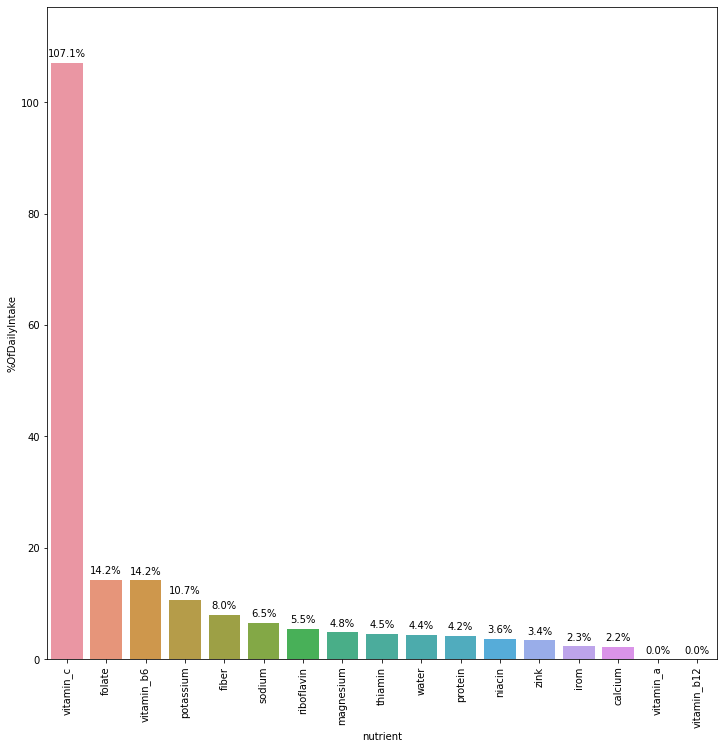

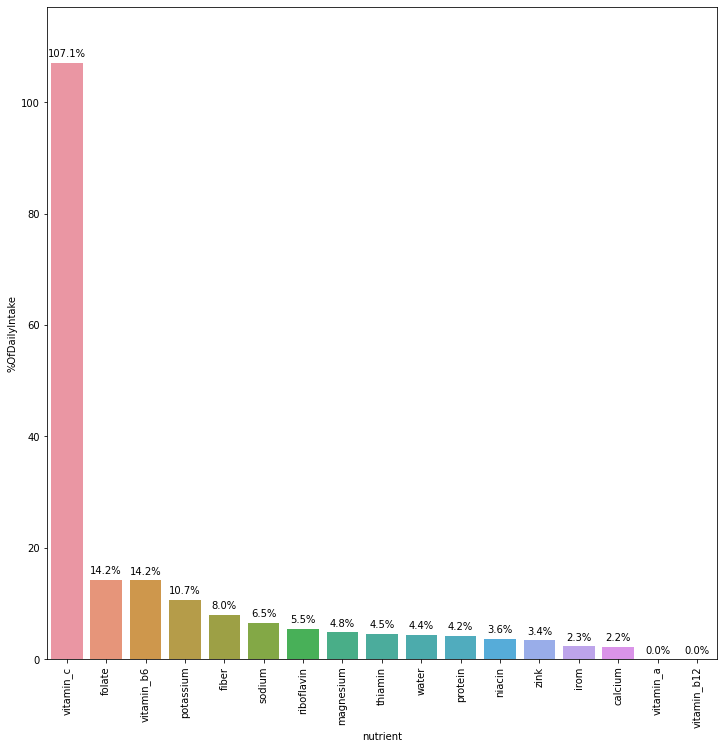

In [11]:
dailyintake_graph(result)

In [12]:
filename = "../data/Nutritional_values.csv"

df = nutrition_prep(filename)
df.head()

,protein,water,fiber,vitamin_a,thiamin,riboflavin,niacin,vitamin_b6,vitamin_b12,folate,vitamin_c,calcium,irom,magnesium,potassium,sodium,zink
name,,,,,,,,,,,,,,,,,
Cornstarch,0.26,0.00832,0.9,0.0,0.000,0.000,0.000,0.000,0.00,0.0,0.0,2.0,0.47,3.0,3.0,9.0,0.06
"Nuts, pecans",9.17,0.00352,9.6,16.8,0.660,0.130,1.167,0.210,0.00,22.0,1.1,70.0,2.53,121.0,410.0,0.0,4.53
"Eggplant, raw",0.98,0.09230,3.0,6.9,0.039,0.037,0.649,0.084,0.00,22.0,2.2,9.0,0.23,14.0,229.0,2.0,0.16
"Teff, uncooked",13.30,0.00882,8.0,2.7,0.390,0.270,3.363,0.482,0.00,0.0,0.0,180.0,7.63,184.0,427.0,12.0,3.63
"Sherbet, orange",1.10,0.06610,1.3,13.8,0.027,0.097,0.063,0.023,0.13,4.0,2.3,54.0,0.14,8.0,96.0,46.0,0.48


In [13]:
def nutrient_selector(nutrientname, df):
    try:
        return df[nutrientname].sort_values(ascending = False)
    except:
        return "More than one row selected"

In [14]:
nutrient_selector("water", df)

name
Water, NAYA, non-carbonated, bottled                                                  0.1
Beverages, Glacial Natural spring water, ICELANDIC                                    0.1
Beverages, POLAND SPRING, bottled, water                                              0.1
Beverages, CALISTOGA, non-carbonated, bottled, water                                  0.1
Beverages, CRYSTAL GEYSER, non-carbonated, bottled, water                             0.1
                                                                                     ... 
Oil, ultra low linolenic, soy, industrial                                             0.0
Shortening confectionery, coconut (hydrogenated) and or palm kernel (hydrogenated)    0.0
Oil, (partially hydrogenated), salad or cooking, soybean                              0.0
Oil, roasting nuts, oil sprays, principal uses candy coatings, coconut, industrial    0.0
Sweetener, herbal extract powder from Stevia leaf                                     0.0
Name:

In [15]:
filter1 = ["Beverages", "supplement", "nutritional"]

beverages = df.index.str.contains(filter1[0])
supplements = df.index.str.contains(filter1[1])
nutritional = df.index.str.contains(filter1[2])

In [16]:
def extra_filters(df, *to_filter):
    # Empty list for filters
    filter_list = []
    # Add all the filters in the function arguments
    for filter_ in to_filter: filter_list.append(filter_)

    
    filter_ = df.index.str.contains(to_filter)

    return df[filter_ == False]

In [17]:
df1 = extra_filters(df, "supplement")
df2 = extra_filters(df1, "nutritional")
df1.shape

TypeError: first argument must be string or compiled pattern

In [44]:
df.shape

(8789, 17)

In [53]:
def one_filter(df, to_filter):
    
    filter_ = df.index.str.contains(to_filter)
    return df[filter_ == False]

In [72]:
def several_filters(df, to_filter_list):

    for f_ in to_filter_list:
        df = one_filter(df, f_)

    return df

In [77]:
#test = one_filter(df, "nutritional")
test = several_filters(df, ["nutritional", "supplement", "Beverages"])
test.shape

(8504, 17)

In [64]:
df.shape

(8789, 17)

In [78]:
def nutritionfacts_graph1(df, nutrient):
    fig, ax1 = plt.subplots(1, 1, figsize = (12, 12))
    sns.barplot(x = df.index, y = nutrient, data = df, ax = ax1)

    return fig

In [19]:
test = df.head(10)

In [ ]:
#nutritionfacts_graph1(test, "protein")

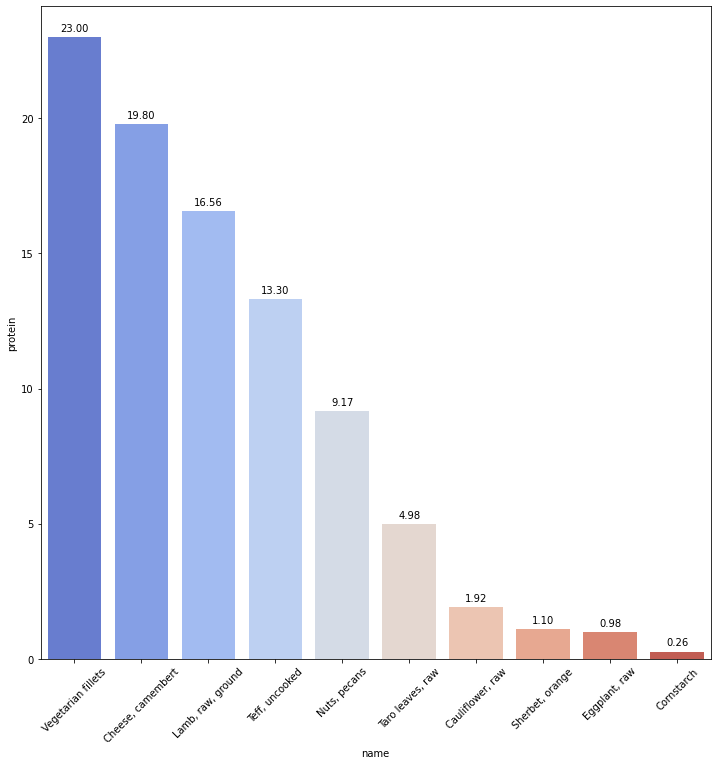

In [31]:
test = test.sort_values(by = "protein", ascending = False)
fig, ax1 = plt.subplots(1, 1, figsize = (12, 12))
splot = sns.barplot(x = test.index, y = test["protein"], data = test, palette = "coolwarm", ax = ax1)

#sns.color_palette("light:#5A9", as_cmap=True)

plt.xticks(rotation = 45)

for p in splot.patches:
            splot.annotate(format(p.get_height(), '.2f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')

In [22]:
test

,protein,water,fiber,vitamin_a,thiamin,riboflavin,niacin,vitamin_b6,vitamin_b12,folate,vitamin_c,calcium,irom,magnesium,potassium,sodium,zink
name,,,,,,,,,,,,,,,,,
Cornstarch,0.26,0.00832,0.9,0.0,0.000,0.000,0.000,0.000,0.00,0.0,0.0,2.0,0.47,3.0,3.0,9.0,0.06
"Nuts, pecans",9.17,0.00352,9.6,16.8,0.660,0.130,1.167,0.210,0.00,22.0,1.1,70.0,2.53,121.0,410.0,0.0,4.53
"Eggplant, raw",0.98,0.09230,3.0,6.9,0.039,0.037,0.649,0.084,0.00,22.0,2.2,9.0,0.23,14.0,229.0,2.0,0.16
"Teff, uncooked",13.30,0.00882,8.0,2.7,0.390,0.270,3.363,0.482,0.00,0.0,0.0,180.0,7.63,184.0,427.0,12.0,3.63
"Sherbet, orange",1.10,0.06610,1.3,13.8,0.027,0.097,0.063,0.023,0.13,4.0,2.3,54.0,0.14,8.0,96.0,46.0,0.48
"Cauliflower, raw",1.92,0.09207,2.0,0.0,0.050,0.060,0.507,0.184,0.00,57.0,48.2,22.0,0.42,15.0,299.0,30.0,0.27
"Taro leaves, raw",4.98,0.08566,3.7,1447.5,0.209,0.456,1.513,0.146,0.00,126.0,52.0,107.0,2.25,45.0,648.0,3.0,0.41
"Lamb, raw, ground",16.56,0.05947,0.0,0.0,0.110,0.210,5.960,0.130,2.31,18.0,0.0,16.0,1.55,21.0,222.0,59.0,3.41
"Cheese, camembert",19.80,0.05180,0.0,246.0,0.028,0.488,0.630,0.227,1.30,62.0,0.0,388.0,0.33,20.0,187.0,842.0,2.38


In [57]:
def one_filter(df, to_filter, out = True):
    
    filter_ = df.index.str.contains(to_filter)

    if out:
        return df[filter_ == False]
    return df[filter_]


def several_filters(df, to_filter_list, out = True):

    if out == False:
        pos_df = pd.DataFrame(columns = df.columns)

        for f_ in to_filter_list:
            pos_filter = one_filter(df, f_, out)
            pos_df = pd.concat([pos_df, pos_filter])

        return pos_df

    else:
        for f_ in to_filter_list:
            neg_df = one_filter(df, f_, out)

        return neg_df

In [58]:
test = several_filters(df, ["soy", "chicken"], out = False)
test.shape

(236, 17)

In [64]:
test2 = one_filter(df, "chicken", out = False)
test2.shape

(139, 17)

In [2]:
testlist = [False, True, False, False]

True in testlist

True